## Backtest using clusters from QVV and then rank by momentum of top 20

In [1]:
import numpy as np
import pandas as pd
import norgatedata 
import datetime
import pickle
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline 

[2020-10-31 19:51:31.869707] WARNING: Norgate Data: **PACKAGE VERSION WARNING*** You have version (1.0.31) of the norgatedata package installed.  A newer version 1.0.52 is available and is a recommended upgraded.
[2020-10-31 19:51:31.870388] INFO: Norgate Data: NorgateData package v1.0.31: Init complete


In [2]:
import norgate as ng

In [3]:
path = 'D:/Udacity/final/'

Import prices 

In [15]:
russell_prices = pd.read_csv(path + 'russell_prices_pre_f.csv',parse_dates=True,index_col = 0)

Import our clusters + constituent time series from cluster results

In [4]:
clstr_td_ct = pickle.load(open(path + 'qvv_clstr_ts_f.pkl','rb'))

Import constituents

In [5]:
russell_constituent = pd.read_csv(path + 'russell_constituent_pre_f.csv',parse_dates=True,index_col = 0)
russell_constituent = russell_constituent.loc['2003-01-02':]

In [6]:
russell_ret6 = pd.read_csv(path + 'russell_ret6_f.csv',parse_dates=True,index_col=0)

Extract end of month dates

In [7]:
dateRange = []  
tempYear = None  
tempTradeDays = russell_constituent.index
dictYears = tempTradeDays.groupby(tempTradeDays.year)
for yr in dictYears.keys():
    tempYear = pd.DatetimeIndex(dictYears[yr]).groupby(pd.DatetimeIndex(dictYears[yr]).month)
    for m in tempYear.keys():
        dateRange.append(max(tempYear[m]))
dateRange = pd.DatetimeIndex(dateRange).sort_values()

In [8]:
month_const = russell_constituent.reindex(dateRange)

In [9]:
symbol_watchlist = list(month_const.columns)

In [16]:
return_series = russell_prices.ffill()/russell_prices.ffill().shift(1) - 1
return_series = return_series.loc['2003-01-31':]

we now apply crossectional momentum to the clusters. 
This one is 6 month return

In [37]:
clstr_ts_qvvm = {}
for k,df in clstr_td_ct.items():
    #convert to monthly index
    dff = df.reindex(month_const.index)
    clstr_ts = []
    for date,row in dff.iterrows():
        # we extract cluster symbols at each observation where constiteunt > 0, and then we rank by top 20 momentum using 6mth ret
        rank_mom20 = russell_ret6.loc[date].loc[dff.loc[date][dff.loc[date] > 0].index].sort_values(ascending=False).index[:20]
        ts_temp = [1 if sym in rank_mom20 else 0 for sym in symbol_watchlist]
        clstr_ts.append(ts_temp)
        
    #create a dataframe for each cluster (still in monthly observations)
    temp_df = pd.DataFrame(data = np.array(clstr_ts), index= month_const.index, columns =  month_const.columns)
    # we reindex based on the full time series and then ffill to prepare for backtesting
    clstr_ts_qvvm[k] = temp_df.reindex(russell_constituent.index).ffill()

#construct a portfolio value dictionary that keeps all cluster's backtest information in a dataframe 
backtest_clstr_series = {}

for k,df in clstr_ts_qvvm.items():
    # shift constiteunts since we avoid look forward bias, we will get signal on rebalance day, and then 
    # invest on next day close, which means the returns will be calculated the next nextday of our invest day
    temp_df  = (return_series * df.loc['2003-01-31':].shift(2)).fillna(0)
    #find total return by taking sum
    temp_df['tot_ret'] = temp_df.sum(axis=1)
    #find total assets at those observations (notice shift 2 for consistency)
    temp_df['n_assets'] = df.sum(axis=1).reindex(temp_df.index).shift(2)
    #find real returns by dividing total return by number of assets (equally invested)
    temp_df['w_ret'] = temp_df['tot_ret'] / temp_df['n_assets']
    
    temp_df['port'] = (temp_df['w_ret'] + 1).cumprod() * 10000
    #fill na with 10000 for the first two rows
    temp_df['port'].fillna(10000,inplace=True)
    
    backtest_clstr_series[k] = temp_df
    

clstr_ts_qvvm6 = clstr_ts_qvvm.copy()

In [67]:
# pickle.dump(clstr_ts_qvvm6, open('D:/Udacity/qvvm6_clstr_ts.pkl','wb'))

In [11]:
def get_years_past(series: pd.Series):
    """
    Computes how many years between start and end 
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float in years
    """
    
    start_date = series.index[0]
    end_date = series.index[-1]
    return (end_date - start_date).days / 365.25
 
def calculate_cagr(series: pd.Series):
    """
    Computes cumulative annual growth rate
   
    Parameters
    ----------
    series: Series
        Time Series
    Returns
    -------
    float 
    """
    
    start_price = series.iloc[0]
    end_price = series.iloc[-1]
    value_factor = end_price / start_price
    year_past = get_years_past(series)
    return (value_factor ** (1 / year_past)) - 1

def calculate_log_return_series(series: pd.Series):
    """
    Computes log daily returns
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    shifted_series = series.shift(1, axis=0)
    return pd.Series(np.log(series / shifted_series))
 
def calculate_annualized_volatility(series: pd.Series):
    """
    Computes annualized volatility
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    years_past = get_years_past(series)
    return_series = calculate_log_return_series(series)
    entries_per_year = return_series.shape[0] / years_past
    return return_series.std() * np.sqrt(entries_per_year)

def calculate_maxdd(series: pd.Series):
    """
    Computes maximum drawdown
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    port = series.copy()
    running_max = np.maximum.accumulate(port)

    #Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    #Calculate the percentage drawdown
    drawdown = (port)/running_max - 1
    
    #Plot results
    return drawdown.min()

def calculate_cum_return(series: pd.Series):
    """
    Computes cumulative return
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    start_price = series.iloc[0]
    end_price = series.iloc[-1]
    
    return end_price/start_price - 1

def calculate_sr(return_series: pd.Series):
    """
    Computes Sharpe Ratio
   
    Parameters
    ----------
    series: Series
        Time Series
   
    Returns
    -------
    float 
    """
    Sharpe_Ratio = return_series.mean() / return_series.std()
    
    return (252 ** 0.5) * Sharpe_Ratio

def plot_drawdown(port_value,label=None):
    """
    Plots the drawdown 
   
    Parameters
    ----------
    port_value: Series
        Time series indicating our portfolio value
    label: str
        Label of plot 
    """
    
    port = port_value.copy()
    running_max = np.maximum.accumulate(port)

    #Ensure the value never drops below 1
    running_max[running_max<1] = 1
    
    #Calculate the percentage drawdown
    drawdown = (port)/running_max - 1
    
    #Plot results
    drawdown.plot(label=label)
    

In [39]:
def performance_metrics(backtest_clstr_series):
    
    """
    Plots our equity and drawdown for all clusters. Also returns performance metrics. This is for four
    factors analysis with quality, volatility, value and momentum. 
   
    Parameters
    ----------
    backtest_clstr_series : dict
        Dictionary containing dataframes where each dataframe corresponds to each cluster's backtest
        
    Returns
    -------
    metric_df : DataFrame 
        Performance metrics of all clusters
    """
    plt.figure(figsize=(18,10))
    for k,df in backtest_clstr_series.items():
        df['port'].plot(label='clstr' + str(k))

    plt.legend()
    plt.ylabel('Equity')
    plt.figure(figsize=(18,10))

    for k,df in backtest_clstr_series.items():
        plot_drawdown(df['port'].dropna(),label = 'clstr' + str(k))

    plt.legend()
    plt.ylabel('Drawdown')

    metric_list = []
    c_index = []
    metric_columns = ['CAGR','Annual Vol','MaxDD','Cum Returns','Sharp Ratio']
    for k,df in backtest_clstr_series.items():
        temp_list = []
        temp_list.append(calculate_cagr(df['port']))
        temp_list.append(calculate_annualized_volatility(df['port']))
        temp_list.append(calculate_maxdd(df['port']))
        temp_list.append(calculate_cum_return(df['port']))
        temp_list.append(calculate_sr(df['w_ret']))

        metric_list.append(temp_list)

        c_index.append('Cluster ' + str(k))


    metric_np = np.asarray(metric_list)

    metric_df = pd.DataFrame(data=metric_np,index=c_index,columns=metric_columns)
    
    return metric_df


In [42]:
def performance_metrics_trend(backtest_clstr_series,port):
    """
    Plots our equity and drawdown for all clusters. Also returns performance metrics. This is for four
    factors analysis with quality, volatility, value and momentum, and also with time series momentum. 
    Additionally, we plot SPX's performance as well.
   
    Parameters
    ----------
    backtest_clstr_series : dict
        Dictionary containing dataframes where each dataframe corresponds to each cluster's backtest
        
    Returns
    -------
    metric_df : DataFrame 
        Performance metrics of all clusters
    """
    # plot port values
    plt.figure(figsize=(18,10))
    for k,df in backtest_clstr_series.items():
        df['port_t' + port].plot(label='clstr' + str(k))
    
    backtest_clstr_series[0]['port_spx_bench'].plot(label='SPX') # for spx use backtest_clstr_series[0] 
    # it's the same for backtest_clstr_series[3 or 4] 
    plt.legend()
    plt.ylabel('Equity')
    # plot drawdowns

    plt.figure(figsize=(18,10))

    for k,df in backtest_clstr_series.items():
        plot_drawdown(df['port_t' + port].dropna(),label = 'clstr' + str(k))
    
    plot_drawdown(backtest_clstr_series[0]['port_spx_bench'],label='SPX') # spx
    plt.legend()
    plt.ylabel('Drawdown')
    # create a metrics df
    #keep metric columns
    metric_list = []
    #keep cluster index names
    c_index = []
    metric_columns = ['CAGR','Annual Vol','MaxDD','Cum Returns','Sharp Ratio']
    for k,df in backtest_clstr_series.items():
        temp_list = []
        temp_list.append(calculate_cagr(df['port_t' + port]))
        temp_list.append(calculate_annualized_volatility(df['port_t' + port]))
        temp_list.append(calculate_maxdd(df['port_t' + port]))
        temp_list.append(calculate_cum_return(df['port_t' + port]))
        temp_list.append(calculate_sr(df['w_ret_' + port]))

        metric_list.append(temp_list)

        c_index.append('Cluster ' + str(k))
        
    temp_list = []
    temp_list.append(calculate_cagr(backtest_clstr_series[0]['port_spx_bench']))
    temp_list.append(calculate_annualized_volatility(backtest_clstr_series[0]['port_spx_bench']))
    temp_list.append(calculate_maxdd(backtest_clstr_series[0]['port_spx_bench']))
    temp_list.append(calculate_cum_return(backtest_clstr_series[0]['port_spx_bench']))
    temp_list.append(calculate_sr(backtest_clstr_series[0]['spx_ret']))
    
    metric_list.append(temp_list)
    c_index.append('SPX')
    
    metric_np = np.asarray(metric_list)

    metric_df = pd.DataFrame(data=metric_np,index=c_index,columns=metric_columns)
    
    return metric_df


Backtest for QVVM

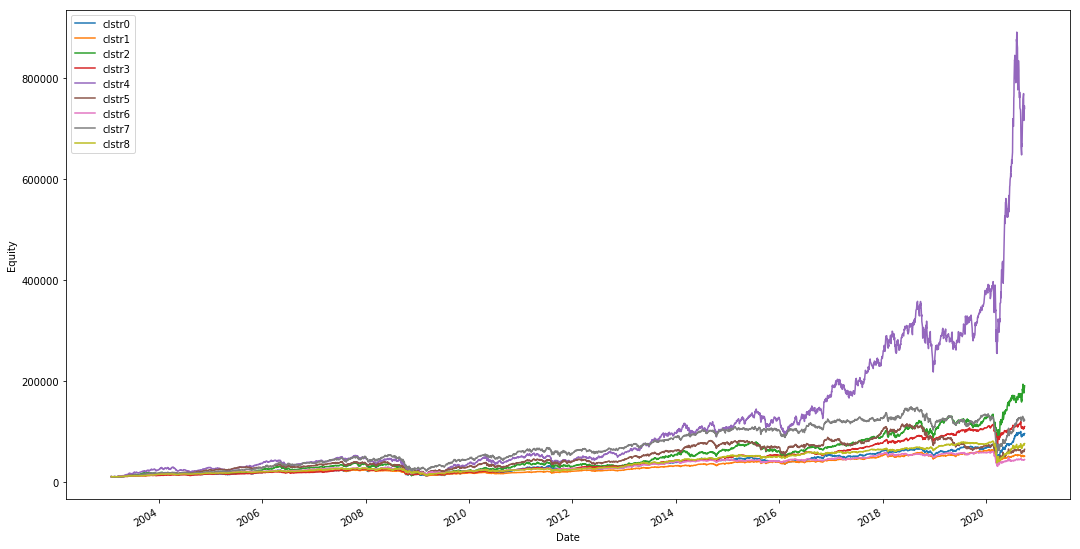

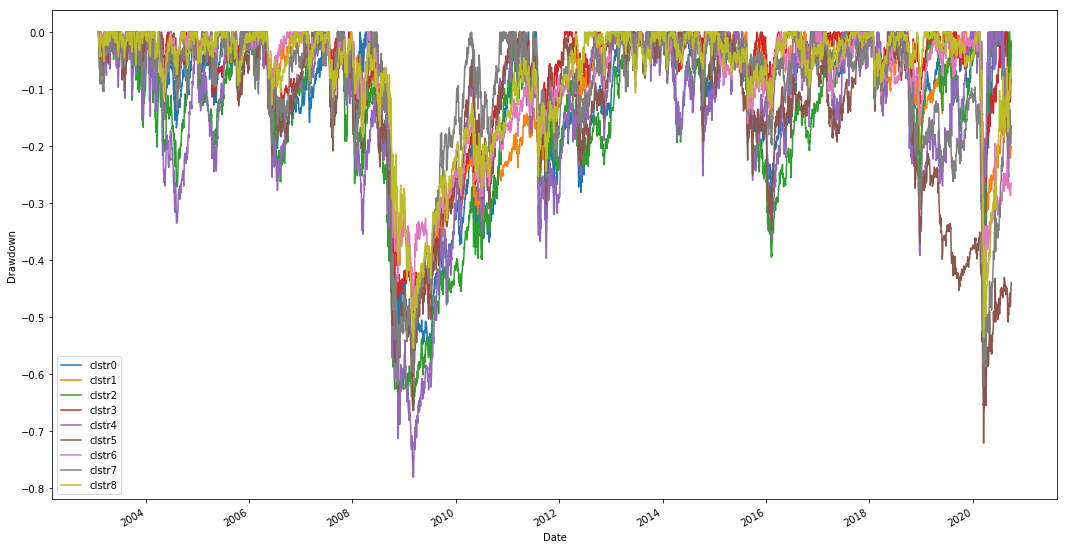

In [41]:
metric_df6 = performance_metrics(backtest_clstr_series)

In [19]:
metric_df6

,CAGR,Annual Vol,MaxDD,Cum Returns,Sharp Ratio
Cluster 0,0.136192,0.273359,-0.602716,8.536322,0.605281
Cluster 1,0.096374,0.190065,-0.515972,4.078653,0.582565
Cluster 2,0.181449,0.303593,-0.692511,18.010015,0.702359
Cluster 3,0.144949,0.191232,-0.504599,9.921260,0.805925
Cluster 4,0.275876,0.362393,-0.780573,72.922526,0.856626
Cluster 5,0.110868,0.309367,-0.720749,5.404521,0.496327
Cluster 6,0.087427,0.201959,-0.489577,3.394367,0.518782
Cluster 7,0.152242,0.283597,-0.620344,11.217310,0.645401
Cluster 8,0.121212,0.232816,-0.554475,6.543632,0.613720


In [ ]:
# metric_df_qvv = pd.read_csv(path + 'qvv_backtest_metrics.csv',index_col = 0)

# Adding Trend Filter (Time Series Momentum)

Let's apply our trend filter by using ma100. Here we compare using SPX, Russell 1000, and Russell 3000 as a our trend filter. 

In [20]:
spx = ng.hist_sym('$SPX','2000-01-01')
russell_1k = ng.hist_sym('$RUI','2000-01-01')
russell_3k = ng.hist_sym('$RUA','2000-01-01')

In [21]:
spx['ret6'] = spx['Close']/spx['Close'].shift(106) - 1
russell_1k['ret6'] = russell_1k['Close']/russell_1k['Close'].shift(106) - 1
russell_3k['ret6'] = russell_3k['Close']/russell_3k['Close'].shift(106) - 1


In [22]:
spx['ma200'] = spx['Close'].rolling(200).mean()
russell_1k['ma200'] = russell_1k['Close'].rolling(200).mean()
russell_3k['ma200'] = russell_3k['Close'].rolling(200).mean()



In [24]:
spx['trend_f'] = np.where(spx['Close'] > spx['ma200'],1,0)
russell_1k['trend_f'] = np.where(russell_1k['Close'] > russell_1k['ma200'],1,0)
russell_3k['trend_f'] = np.where(russell_3k['Close'] > russell_3k['ma200'],1,0)


Creating spx returns for benchmark

In [25]:
spx['ret'] = spx['Close']/spx['Close'].shift(1) - 1
russell_1k['ret'] = russell_1k['Close']/russell_1k['Close'].shift(1) - 1
russell_3k['ret'] = russell_3k['Close']/russell_3k['Close'].shift(1) - 1

In [44]:
backtest_clstr_series = {}

for k,df in clstr_ts_qvvm6.items():
    # shift constiteunts since we avoid look forward bias, we will get signal on rebalance day, and then 
    # invest on next day close, which means the returns will be calculated the next nextday of our invest day
    temp_df  = (return_series * df.loc['2003-01-31':].shift(2)).fillna(0)
    #find total return by taking sum
    temp_df['tot_ret'] = temp_df.sum(axis=1)
    #find total assets at those observations (notice shift 2 for consistency)
    temp_df['n_assets'] = df.sum(axis=1).reindex(temp_df.index).shift(2)
    #find real returns by dividing total return by number of assets (equally invested)
    temp_df['w_ret'] = temp_df['tot_ret'] / temp_df['n_assets']
    
    temp_df['trend_f_spx'] = spx['trend_f'].reindex(dateRange).reindex(temp_df.index).ffill().shift(2).fillna(0)
    temp_df['trend_f_rui'] = russell_1k['trend_f'].reindex(dateRange).reindex(temp_df.index).ffill().shift(2).fillna(0)
    temp_df['trend_f_rua'] = russell_3k['trend_f'].reindex(dateRange).reindex(temp_df.index).ffill().shift(2).fillna(0)
    
    temp_df['port_tspx'] = (temp_df['w_ret'] * temp_df['trend_f_spx'] + 1).cumprod() * 10000
    temp_df['port_trui'] = (temp_df['w_ret'] * temp_df['trend_f_rui'] + 1).cumprod() * 10000
    temp_df['port_trua'] = (temp_df['w_ret'] * temp_df['trend_f_rua'] + 1).cumprod() * 10000
    
    temp_df['w_ret_spx'] = temp_df['w_ret'] * temp_df['trend_f_spx'] 
    temp_df['w_ret_rui'] = temp_df['w_ret'] * temp_df['trend_f_rui'] 
    temp_df['w_ret_rua'] = temp_df['w_ret'] * temp_df['trend_f_rua'] 
    #fill na with 10000 for the first two rows
    temp_df['port_tspx'].fillna(10000,inplace=True)
    temp_df['port_trui'].fillna(10000,inplace=True)
    temp_df['port_trua'].fillna(10000,inplace=True)
    
    temp_df['spx_ret'] = spx['ret'].reindex(temp_df.index)
    temp_df['spx_ret'].iloc[0] = 0
    
    temp_df['port_spx_bench'] = (temp_df['spx_ret']  + 1).cumprod() * 10000
    
    backtest_clstr_series[k] = temp_df


Our Backtest using QVVM + SPX Trend Filter

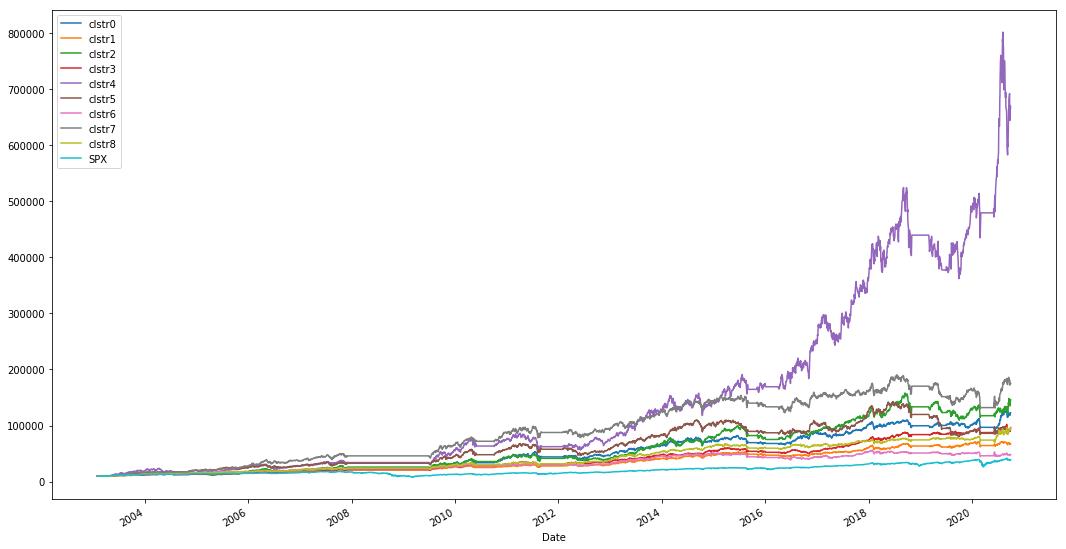

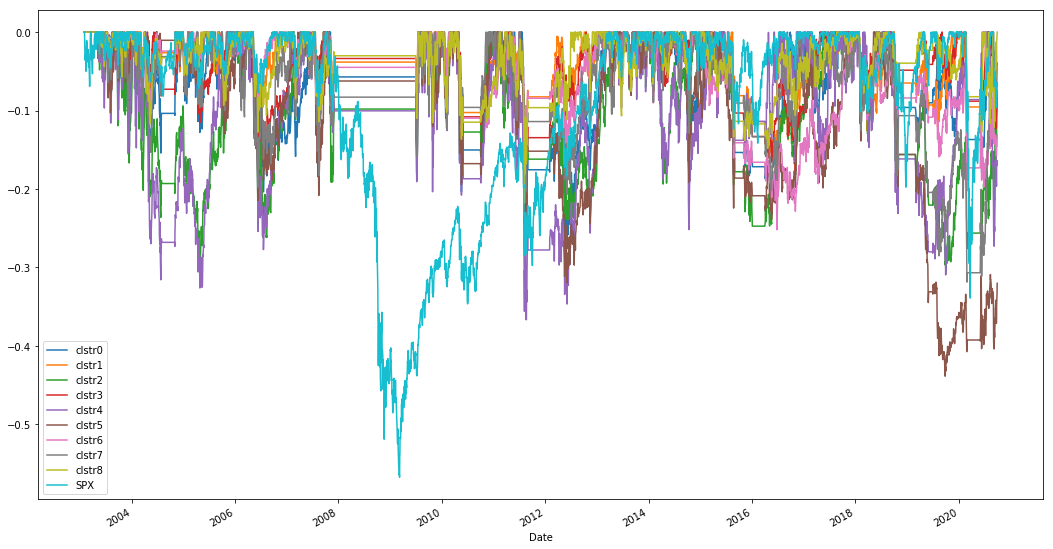

In [27]:
metric_df6_spx = performance_metrics_trend(backtest_clstr_series,'spx')

Our Backtest using QVVM + Russell 1000 Trend Filter

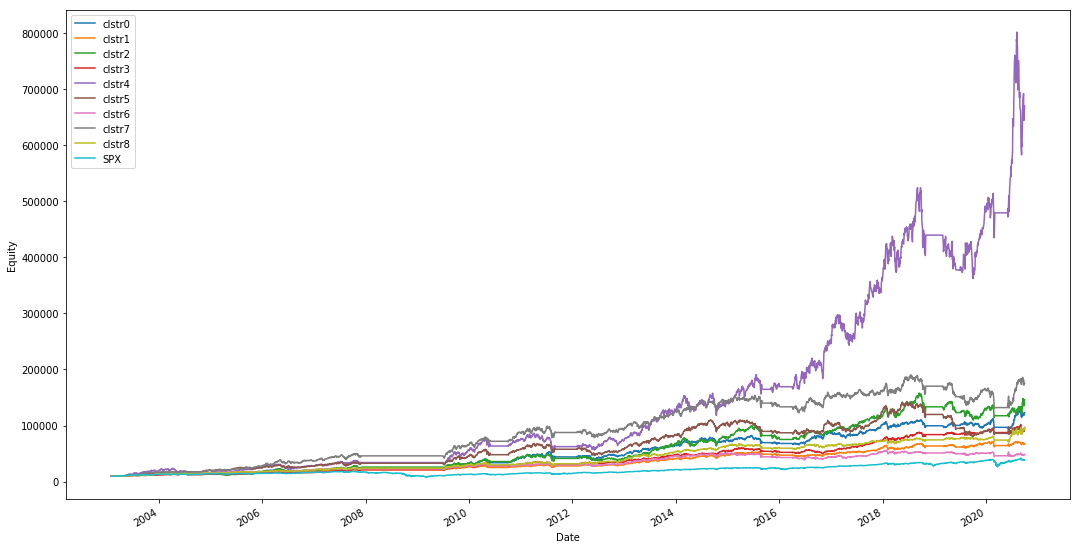

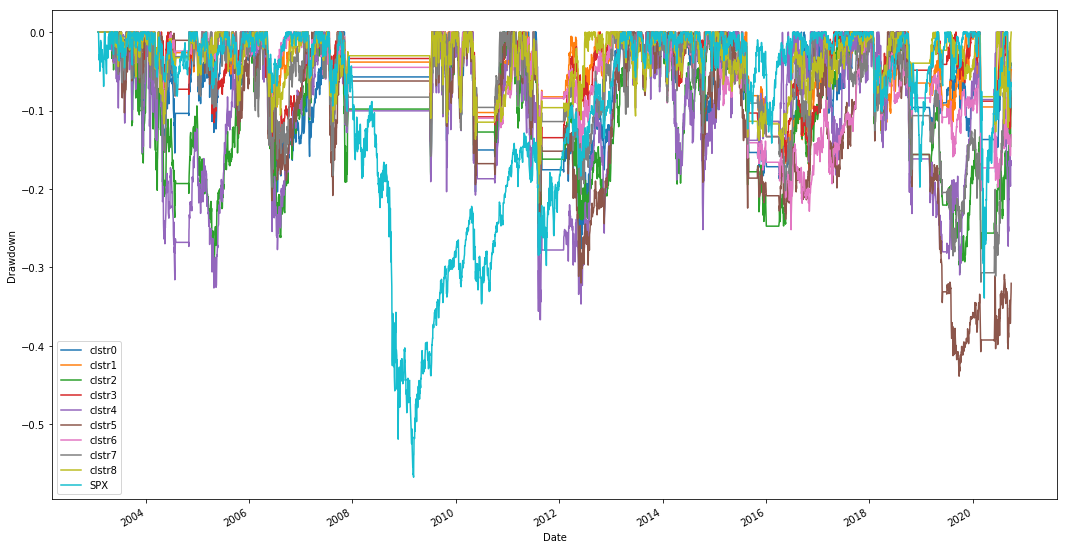

In [45]:
metric_df6_rui = performance_metrics_trend(backtest_clstr_series,'rui')

Our Backtest using QVVM + Russell 3000 Trend Filter

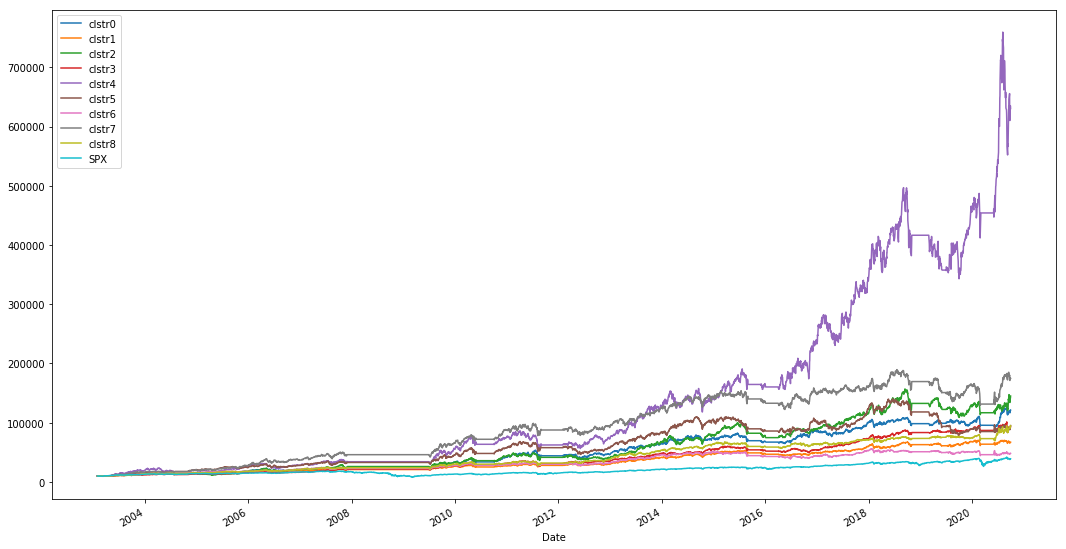

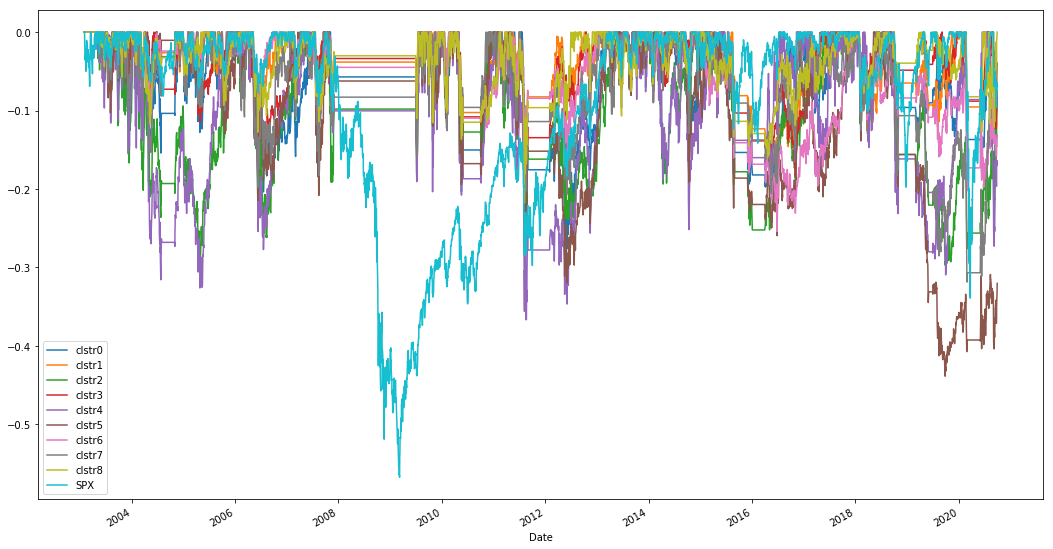

In [29]:
metric_df6_rua = performance_metrics_trend(backtest_clstr_series,'rua')

In [30]:
metric_df6_spx

,CAGR,Annual Vol,MaxDD,Cum Returns,Sharp Ratio
Cluster 0,0.152637,0.193438,-0.275911,11.291498,0.833067
Cluster 1,0.114371,0.129280,-0.176748,5.770711,0.904417
Cluster 2,0.163904,0.218937,-0.306829,13.595457,0.803834
Cluster 3,0.134831,0.140927,-0.238143,8.336560,0.970881
Cluster 4,0.268292,0.267070,-0.366910,65.534705,1.024468
Cluster 5,0.136929,0.201035,-0.438899,8.646145,0.741055
Cluster 6,0.093436,0.135489,-0.252059,3.843528,0.729944
Cluster 7,0.176142,0.196248,-0.318905,16.557021,0.926932
Cluster 8,0.136680,0.146754,-0.218047,8.608861,0.948485
SPX,0.080072,0.193017,-0.567754,2.897941,0.496847


In [46]:
metric_df6_rui

,CAGR,Annual Vol,MaxDD,Cum Returns,Sharp Ratio
Cluster 0,0.152637,0.193438,-0.275911,11.291498,0.833067
Cluster 1,0.114371,0.129280,-0.176748,5.770711,0.904417
Cluster 2,0.163904,0.218937,-0.306829,13.595457,0.803834
Cluster 3,0.134831,0.140927,-0.238143,8.336560,0.970881
Cluster 4,0.268292,0.267070,-0.366910,65.534705,1.024468
Cluster 5,0.136929,0.201035,-0.438899,8.646145,0.741055
Cluster 6,0.093436,0.135489,-0.252059,3.843528,0.729944
Cluster 7,0.176142,0.196248,-0.318905,16.557021,0.926932
Cluster 8,0.136680,0.146754,-0.218047,8.608861,0.948485
SPX,0.080072,0.193017,-0.567754,2.897941,0.496847


In [32]:
metric_df6_rua

,CAGR,Annual Vol,MaxDD,Cum Returns,Sharp Ratio
Cluster 0,0.151805,0.193294,-0.275911,11.135693,0.829800
Cluster 1,0.113717,0.129014,-0.185242,5.700857,0.901456
Cluster 2,0.163480,0.218504,-0.306829,13.501896,0.803312
Cluster 3,0.134409,0.140743,-0.238143,8.275423,0.969316
Cluster 4,0.264443,0.266619,-0.366910,62.056835,1.014341
Cluster 5,0.136017,0.200706,-0.438899,8.510415,0.737925
Cluster 6,0.093246,0.135144,-0.254344,3.828731,0.730178
Cluster 7,0.175836,0.195879,-0.318905,16.476432,0.926976
Cluster 8,0.135771,0.146601,-0.218047,8.474068,0.943856
SPX,0.080072,0.193017,-0.567754,2.897941,0.496847
